# Variant pair sets: functional eQTLs and null controls

This notebook builds two variant-pair sets from the Cai et al. epistatic eQTL resource and TopLD:

1. **Functional (eQTL-connected) set**: Reported evQTL–partial eQTL pairs with distance &lt; 6 kb.
2. **Null (correlated) set**: Pairs from TopLD where one variant is the same anchor (lead eQTL) as in the functional set and the other is in LD with it—same regions and linkage, but not necessarily functional.

Then we compare the two sets on allele frequency (AF), distance, and linkage (R²).

In [1]:
# Paths and constants (set these for your environment)
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm

# Ensure repo root is on path so "notebooks" can be imported
ROOT = Path.cwd()
for _ in range(4):
    if (ROOT / "notebooks" / "paper_data_config.py").exists():
        break
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from notebooks.paper_data_config import data_dir

# Inputs
EPISTASIS_EQTLS_PATH = "/tamir2/nicolaslynn/projects/genomenet/genomenet/notebooks/data_generation_final/epistasis_eqtls.csv"  # Cai et al. table (tab-delimited)
LIFTOVER_CHAIN_PATH  = "/tamir2/nicolaslynn/data/UCSC/raw_data/hg19ToHg38.over.chain.gz"
GENE_STRAND_PATH     = "/tamir2/nicolaslynn/projects/dlm_wrappers/genebeddings/assets/benchmarks/gene_strands.csv"
TOPLD_DIR            = "/tamir2/nicolaslynn/data/TopLD/data"  # TopLD EUR chr*_no_filter_0.2_1000000_LD.csv

# Outputs under paper data root
OUT_FUNCTIONAL_CSV   = data_dir() / "lt6000_eqtl_connected.csv"
OUT_NULL_CSV         = data_dir() / "correlated_variants_27K.csv"

MAX_DIST_BP          = 6_000
TOPLD_R2_THRESHOLD   = 0.2
TOPLD_WINDOW_MB      = 1_000_000
BASES = ["A", "C", "G", "T"]




## 1. Helpers: liftover, variant IDs, ref base

## 1b. TopLD per-chrom variant annotations (MAF, CADD, etc.)

TopLD provides `EUR_chr{N}_no_filter_0.2_1000000_info_annotation.csv` (~10 GB each). We do **not** load them all; instead we use `load_topld_annotation_for_variants(variants_df)` which reads each file in chunks and returns a lookup (chrom, Uniq_ID) → {MAF, CADD_phred} only for (chrom, Uniq_ID) pairs present in the given dataframe. Call it with the functional (or null) dataframe before adding MAF1/MAF2.

In [ ]:
import re

def load_topld_annotation_for_variants(
    variants_df,
    topld_dir=TOPLD_DIR,
    suffix="_no_filter_0.2_1000000_info_annotation.csv",
    chrom_col="chrom",
    uniq_id_cols=("Uniq_ID_1", "Uniq_ID_2"),
    chunksize=500_000,
):
    """
    Load TopLD annotations only for (chrom, Uniq_ID) pairs that appear in variants_df.
    Reads each EUR_chr*_info_annotation.csv in chunks to avoid loading ~10 GB per file.
    variants_df must have chrom and either Uniq_ID_1/Uniq_ID_2, or pos1, ref1, alt1, pos2, ref2, alt2 (Uniq_IDs will be built as pos:ref:alt).
    Returns: dict (chrom, Uniq_ID) -> {MAF, CADD_phred, ...}.
    """
    needed = set()
    if uniq_id_cols[0] in variants_df.columns and uniq_id_cols[1] in variants_df.columns:
        for _, row in variants_df[[chrom_col, uniq_id_cols[0], uniq_id_cols[1]]].drop_duplicates().iterrows():
            c = str(row[chrom_col]).strip("chr")
            needed.add((c, str(row[uniq_id_cols[0]])))
            needed.add((c, str(row[uniq_id_cols[1]])))
    else:
        for _, row in variants_df.drop_duplicates().iterrows():
            c = str(row[chrom_col]).strip("chr")
            needed.add((c, f"{int(row['pos1'])}:{row['ref1']}:{row['alt1']}"))
            needed.add((c, f"{int(row['pos2'])}:{row['ref2']}:{row['alt2']}"))
    needed = {(c, u) for (c, u) in needed if u and str(u).strip() and str(u) != "nan"}
    lookup = {}
    for f in sorted(os.listdir(topld_dir)):
        if not f.endswith(suffix) or not f.startswith("EUR_chr"):
            continue
        m = re.search(r"chr(\d+|X)", f)
        if not m:
            continue
        chrom = m.group(1)
        need_uids = {uid for (c, uid) in needed if c == chrom}
        if not need_uids:
            continue
        path = os.path.join(topld_dir, f)
        if "Uniq_ID" not in pd.read_csv(path, nrows=0).columns:
            continue
        for chunk in tqdm(
            pd.read_csv(path, chunksize=chunksize),
            desc=f"chr{chrom} annot",
            leave=False,
        ):
            if "Uniq_ID" not in chunk.columns or "MAF" not in chunk.columns:
                continue
            subset = chunk[chunk["Uniq_ID"].astype(str).isin(need_uids)]
            for _, row in subset.iterrows():
                uid = str(row["Uniq_ID"])
                key = (chrom, uid)
                if key in lookup:
                    continue
                try:
                    maf = float(row["MAF"]) if pd.notna(row["MAF"]) and str(row["MAF"]).strip() not in (".", "") else np.nan
                except (TypeError, ValueError):
                    maf = np.nan
                lookup[key] = {"MAF": maf}
                if "CADD_phred" in chunk.columns and pd.notna(row.get("CADD_phred")):
                    try:
                        lookup[key]["CADD_phred"] = float(row["CADD_phred"])
                    except (TypeError, ValueError):
                        lookup[key]["CADD_phred"] = np.nan
                need_uids.discard(uid)
            if not need_uids:
                break
    print(f"TopLD annotation: {len(lookup)} variants (from {len(needed)} requested)")
    return lookup



In [ ]:
from pyliftover import LiftOver
lo = LiftOver(LIFTOVER_CHAIN_PATH)
GENE_STRAND = pd.read_csv(GENE_STRAND_PATH).set_index('gene_name').Strand.to_dict()

def make_mut_id(row, pos_col='pos1', ref_col='ref1', var_col='alt1', chrom_col='chrom', gene_col='gene'):
    rev = GENE_STRAND.get(row[gene_col], False)
    s = 'N' if rev else 'P'
    chrom = str(row[chrom_col]).strip('chr')
    return f"{row[gene_col]}:{chrom}:{int(row[pos_col])}:{row[ref_col]}:{row[var_col]}:{s}"

def ensembl_mut_id2(mid):
    """Gene:chrom:pos:ref:alt:strand -> chrom_pos_ref/alt for AF lookup."""
    parts = mid.split(':')
    return f"{parts[1]}_{parts[2]}_{parts[3]}/{parts[4]}"

def _safe_liftover_one(chrom, pos):
    try:
        res = lo.convert_coordinate(f"chr{str(chrom).strip('chr')}", int(pos), "+")
        if not res:
            return np.nan
        return int(res[0][1])
    except Exception:
        return np.nan

# Ref base from reference genome (optional: requires seqmat)
try:
    from seqmat import SeqMat
    def _get_ref_base(chrom, pos):
        b = SeqMat.from_fasta("hg38", f"chr{chrom}", int(pos), int(pos)).seq
        return b if b and len(b) == 1 and b in BASES else None
except ImportError:
    def _get_ref_base(chrom, pos):
        return None  # will use ref from table only


        

## 2. Build functional eQTL pair set (distance &lt; 6 kb)

In [ ]:
data = pd.read_csv(EPISTASIS_EQTLS_PATH, delimiter='\t', nrows=36098)
data["chrom"] = data["evQTL_chrid"].astype(str)
data["pos1"] = data.apply(lambda r: _safe_liftover_one(r.evQTL_chrid, r.evQTL_pos), axis=1)
data["pos2"] = data.apply(lambda r: _safe_liftover_one(r.partial_eQTL_chrid, r.partial_eQTL_pos), axis=1)
data = data.rename(columns={
    "evQTL_Gene": "gene",
    "evQTL_alleles": "ref1_original",
    "evQTL_alt_allele": "alt1",
    "partial_eQTL_alleles": "ref2_original",
    "partial_eQTL_alt_allele": "alt2",
})
data["ref1_original"] = data.ref1_original.str.split("/").str[0]
data["ref2_original"] = data.ref2_original.str.split("/").str[0]
data = data.dropna(subset=["gene", "chrom", "pos1", "pos2", "alt1", "alt2", "ref1_original", "ref2_original"]).copy()

# Ref base: from reference if available, else from table
data["ref1"] = data.apply(lambda r: _get_ref_base(r.chrom, r.pos1) or r.ref1_original, axis=1)
data["ref2"] = data.apply(lambda r: _get_ref_base(r.chrom, r.pos2) or r.ref2_original, axis=1)
data = data[
    data["ref1"].isin(BASES) & data["ref2"].isin(BASES)
    & data["alt1"].isin(BASES) & data["alt2"].isin(BASES)
    & (data["ref1"] != data["alt1"]) & (data["ref2"] != data["alt2"])
].copy()
data["distance"] = (data["pos2"] - data["pos1"]).abs()
data["mut1"] = data.apply(lambda r: make_mut_id(r, pos_col="pos1", ref_col="ref1", var_col="alt1"), axis=1)
data["mut2"] = data.apply(lambda r: make_mut_id(r, pos_col="pos2", ref_col="ref2", var_col="alt2"), axis=1)
data["epistasis_id"] = data["mut1"] + "|" + data["mut2"]

functional_df = data[data.distance < MAX_DIST_BP].copy()
functional_df["set"] = "functional"
print(f"Functional pairs (distance < {MAX_DIST_BP} bp): {len(functional_df)}")




In [ ]:
# Add Uniq_ID for TopLD (needed to build null set from same anchors; MAF/AF added later)
functional_df["Uniq_ID_1"] = functional_df.apply(lambda r: f"{int(r.pos1)}:{r.ref1}:{r.alt1}", axis=1)
functional_df["Uniq_ID_2"] = functional_df.apply(lambda r: f"{int(r.pos2)}:{r.ref2}:{r.alt2}", axis=1)
print(f"Functional pairs (distance < {MAX_DIST_BP} bp): {len(functional_df)} — build null set from these anchors next, then annotate & filter.")




## 3. Build null (correlated) set from TopLD (anchor = lead eQTL)

For each functional pair, the lead (evQTL) position is an anchor. We keep TopLD pairs where **at least one variant is an anchor**, so every null pair has the form (anchor, variant_in_LD_with_anchor).

**Single pass:** Each `EUR_chr*_LD.csv` is read once per chromosome. In the same chunked loop we (1) merge chunk with functional (pmin, pmax) pairs to fill `ld_lookup` (R²/D′) and (2) keep rows where SNP1 or SNP2 is in anchors for the null set. No second pass over the LD files.

In [ ]:
# Single pass per chrom: fill ld_lookup (R²/D′ for functional pairs) and collect null set (anchor-in-LD rows)
ld_lookup = {}  # (chrom, pmin, pmax) -> (R2, Dprime)
matches = []
for chrom, sub in functional_df.groupby("chrom"):
    path = os.path.join(TOPLD_DIR, f"EUR_chr{chrom}_no_filter_{TOPLD_R2_THRESHOLD}_{TOPLD_WINDOW_MB}_LD.csv")
    if not os.path.isfile(path):
        print(f"Skip chr{chrom}: {path} not found")
        continue
    targets = set(sub["pos1"].unique())
    pos_upper = max(targets) + MAX_DIST_BP
    need_pairs = {(min(p1, p2), max(p1, p2)) for p1, p2 in zip(sub["pos1"], sub["pos2"])}
    need_df = pd.DataFrame(list(need_pairs), columns=["pmin", "pmax"])
    for chunk in tqdm(pd.read_csv(path, chunksize=1_000_000), desc=f"chr{chrom}", leave=False):
        chunk = chunk.astype({"SNP1": int, "SNP2": int})
        chunk["pmin"] = chunk[["SNP1", "SNP2"]].min(axis=1)
        chunk["pmax"] = chunk[["SNP1", "SNP2"]].max(axis=1)
        merged = chunk.merge(need_df, on=["pmin", "pmax"], how="inner")
        for _, row in merged.iterrows():
            ld_lookup[(chrom, int(row["pmin"]), int(row["pmax"]))] = (float(row["R2"]), float(row["Dprime"]))
        m = chunk[(chunk["SNP1"].isin(targets)) | (chunk["SNP2"].isin(targets))].copy()
        if not m.empty:
            m["chrom"] = chrom
            matches.append(m)
        chunk_max = max(chunk["SNP1"].max(), chunk["SNP2"].max())
        if chunk_max > pos_upper:
            break

null_df = pd.concat(matches, ignore_index=True)
null_df["distance"] = (null_df["SNP2"] - null_df["SNP1"]).abs()
# Optional: restrict to same distance range as functional set for comparability
null_df = null_df[null_df.distance < MAX_DIST_BP].copy()
null_df["epistasis_id"] = null_df.apply(
    lambda r: f"GENE:{r.chrom}:{r.Uniq_ID_1}|GENE:{r.chrom}:{r.Uniq_ID_2}", axis=1
)
null_df["set"] = "null"
print(f"Null pairs (distance < {MAX_DIST_BP} bp): {len(null_df)}")




In [ ]:
# Annotate functional set with TopLD MAF only (no gnomAD/VEP annotations)
TOPLD_ANNOT = load_topld_annotation_for_variants(functional_df)
functional_df["MAF1"] = functional_df.apply(lambda r: TOPLD_ANNOT.get((str(r.chrom), r.Uniq_ID_1), {}).get("MAF", np.nan), axis=1)
functional_df["MAF2"] = functional_df.apply(lambda r: TOPLD_ANNOT.get((str(r.chrom), r.Uniq_ID_2), {}).get("MAF", np.nan), axis=1)
out_cols = ["epistasis_id", "mut1", "mut2", "distance", "MAF1", "MAF2", "set"]
functional_df[out_cols].to_csv(OUT_FUNCTIONAL_CSV, index=False)
print(f"Saved {len(functional_df)} rows to {OUT_FUNCTIONAL_CSV} (MAF from TopLD only)")




## 2b. Attach R² and D′ to functional pairs (from single-pass ld_lookup)

ld_lookup was filled in the same TopLD pass that built the null set; no second read.

In [ ]:
def get_ld(row):
    pmin, pmax = min(row["pos1"], row["pos2"]), max(row["pos1"], row["pos2"])
    val = ld_lookup.get((row["chrom"], pmin, pmax), (np.nan, np.nan))
    return pd.Series({"R2": val[0], "Dprime": val[1]})

functional_df[["R2", "Dprime"]] = functional_df.apply(get_ld, axis=1)
n_found = functional_df["R2"].notna().sum()
print(f"R²/D′ found in TopLD for {n_found} / {len(functional_df)} functional pairs")

out_cols = ["epistasis_id", "mut1", "mut2", "distance", "MAF1", "MAF2", "set"]
if "R2" in functional_df.columns:
    out_cols.extend(["R2", "Dprime"])
functional_df[out_cols].to_csv(OUT_FUNCTIONAL_CSV, index=False)
print(f"Saved {OUT_FUNCTIONAL_CSV} (with R2/Dprime when available)")



In [ ]:
# Annotate null set with TopLD MAF only
TOPLD_ANNOT = load_topld_annotation_for_variants(null_df)
null_df["MAF1"] = null_df.apply(lambda r: TOPLD_ANNOT.get((str(r.chrom), str(r.Uniq_ID_1)), {}).get("MAF", np.nan), axis=1)
null_df["MAF2"] = null_df.apply(lambda r: TOPLD_ANNOT.get((str(r.chrom), str(r.Uniq_ID_2)), {}).get("MAF", np.nan), axis=1)
null_df.to_csv(OUT_NULL_CSV, index=False)
print(f"Saved {len(null_df)} rows to {OUT_NULL_CSV} (MAF from TopLD only)")




## 4. Compare functional vs null: AF, distance, linkage

We compare the two sets on:
- **Distance** (bp between the two variants)
- **MAF1, MAF2** (minor allele frequency from TopLD info_annotation.csv)
- **Linkage**: **R²** and **D′** from TopLD. The null set has them for every pair; the functional set is looked up in the same TopLD tables when the pair appears (so we can compare linkage across sets).

In [2]:
functional_df = pd.read_csv(f'../Data/{OUT_FUNCTIONAL_CSV}')
null_df = pd.read_csv(f'../Data/{OUT_NULL_CSV}')



In [5]:
from scipy.stats import ks_2samp, mannwhitneyu

def summarize_compare(name_t, name_n, vec_t, vec_n):
    vec_t = np.asarray(vec_t, float)
    vec_n = np.asarray(vec_n, float)
    vec_t = vec_t[np.isfinite(vec_t)]
    vec_n = vec_n[np.isfinite(vec_n)]
    if len(vec_t) < 2 or len(vec_n) < 2:
        return
    ks = ks_2samp(vec_t, vec_n)
    mwu = mannwhitneyu(vec_t, vec_n, alternative="two-sided")
    print(f"  {name_t} vs {name_n}: n = {len(vec_t)} vs {len(vec_n)}")
    print(f"    mean: {vec_t.mean():.4f} vs {vec_n.mean():.4f}  median: {np.median(vec_t):.4f} vs {np.median(vec_n):.4f}")
    print(f"    KS stat={ks.statistic:.4f} p={ks.pvalue:.2e}  MWU p={mwu.pvalue:.2e}")

# print("--- Distance ---")
summarize_compare("functional", "null", functional_df["distance"], null_df["distance"])
# print("\n--- AF1 (lead variant) ---")
# summarize_compare("functional", "null", functional_df["AF1"], null_df["AF1"])
# print("\n--- AF2 (second variant) ---")
# summarize_compare("functional", "null", functional_df["AF2"], null_df["AF2"])




  functional vs null: n = 1451 vs 27343
    mean: 3097.7271 vs 2895.4166  median: 3176.0000 vs 2854.0000
    KS stat=0.0597 p=1.05e-04  MWU p=1.73e-05


In [6]:
# Linkage: R² and D′ (functional set when found in TopLD; null set always)
print("--- Linkage: R² ---")
if "R2" in functional_df.columns and functional_df["R2"].notna().any():
    summarize_compare("functional", "null", functional_df["R2"], null_df["R2"])
    print(f"  Functional: {functional_df['R2'].notna().sum()} / {len(functional_df)} pairs with R² from TopLD")
else:
    print("  Functional: no R² (run LD lookup cell first)")
print("  Null:", null_df["R2"].describe().round(4))
print("\n--- Linkage: D′ ---")
if "Dprime" in functional_df.columns and functional_df["Dprime"].notna().any():
    summarize_compare("functional", "null", functional_df["Dprime"], null_df["Dprime"])
else:
    print("  Functional: no D′ (run LD lookup cell first)")
print("  Null:", null_df["Dprime"].describe().round(4))




--- Linkage (null set only; TopLD R² and D′) ---
count    27343.000000
mean         0.774732
std          0.277946
min          0.200000
25%          0.500000
50%          0.977000
75%          1.000000
max          1.000000
Name: R2, dtype: float64
count    27343.000000
mean         0.987122
std          0.059067
min          0.500000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Dprime, dtype: float64


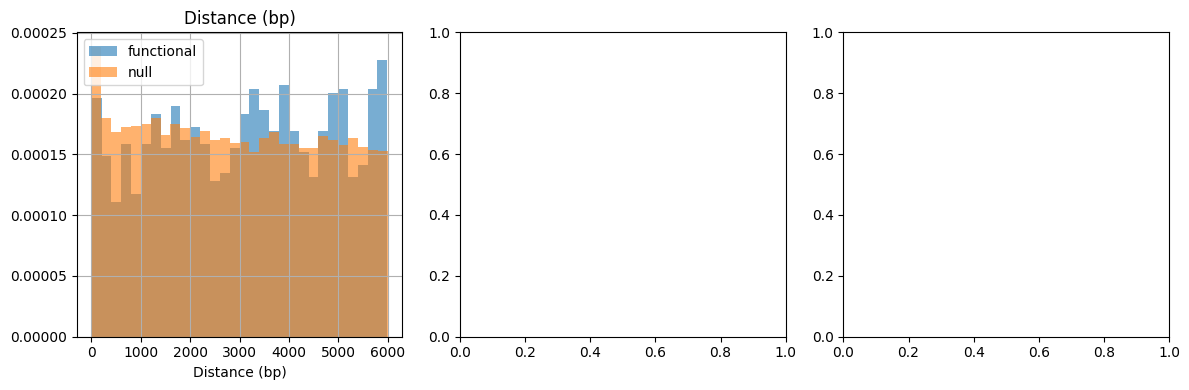

In [8]:
# Optional: simple histograms for distance and AF2
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, (col, label) in zip(axes, [("distance", "Distance (bp)")]): #, ("AF1", "AF1"), ("AF2", "AF2")]):
    functional_df[col].dropna().hist(ax=ax, bins=30, alpha=0.6, label="functional", density=True, color="C0")
    null_df[col].dropna().hist(ax=ax, bins=30, alpha=0.6, label="null", density=True, color="C1")
    ax.set_title(label)
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.show()




In [4]:
null_df

,Unnamed: 0,SNP1,SNP2,Uniq_ID_1,Uniq_ID_2,R2,Dprime,+/-corr,chrom,distance,epistasis_id
0,258,924197,925548,924197:G:A,925548:C:T,1.000,1.0,+,1,1351,GENE:1:924197:G:A|GENE:1:925548:C:T
1,377,980879,982263,980879:T:C,982263:G:A,1.000,1.0,+,1,1384,GENE:1:980879:T:C|GENE:1:982263:G:A
2,378,982263,982458,982263:G:A,982458:C:T,1.000,1.0,+,1,195,GENE:1:982263:G:A|GENE:1:982458:C:T
3,567,1008332,1013199,1008332:T:C,1013199:T:C,0.333,1.0,+,1,4867,GENE:1:1008332:T:C|GENE:1:1013199:T:C
4,570,1009576,1013199,1009576:G:A,1013199:T:C,0.500,1.0,+,1,3623,GENE:1:1009576:G:A|GENE:1:1013199:T:C
...,...,...,...,...,...,...,...,...,...,...,...
27338,1027324,50780662,50783769,50780662:C:G,50783769:G:A,1.000,1.0,+,22,3107,GENE:22:50780662:C:G|GENE:22:50783769:G:A
27339,1027326,50783769,50784700,50783769:G:A,50784700:A:C,1.000,1.0,+,22,931,GENE:22:50783769:G:A|GENE:22:50784700:A:C
27340,1027327,50783769,50785158,50783769:G:A,50785158:A:G,0.900,1.0,+,22,1389,GENE:22:50783769:G:A|GENE:22:50785158:A:G
27341,1027328,50783769,50787089,50783769:G:A,50787089:T:C,1.000,1.0,+,22,3320,GENE:22:50783769:G:A|GENE:22:50787089:T:C
